In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# Paste your specific path inside the quotes
os.chdir('/content/drive/MyDrive/Colab Notebooks/MDLM')

# Verify you are in the right place
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/MDLM


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/MDLM/harry_potter.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f'Length of the dataset: {len(text)} characters')
print(f'First 200 characters:\n{text[:200]}')

Length of the dataset: 6411971 characters
First 200 characters:
THE BOY WHO LIVED 
Mr. and Mrs. Dursley, of number four, Privet Drive, 
were proud to say that they were perfectly normal, 
thank you very much. They were the last people you’d 
expect to be involved 


### Estimate ideal loss on the dataset a priori

Use strong compression algorithm to estimated the theoretical loss lower bound:

$$\text{Ideal Loss} \approx \frac{\text{Compressed Bits}}{N} \times \ln(2)$$

In [ ]:
import lzma

# Calculate theoretical loss limit on this dataset

# Compress
compressed_data = lzma.compress(text.encode('utf-8'))

# Calculate Bits Per Character (BPC)
bpc = (len(compressed_data) * 8) / len(text)

# Convert to Cross Entropy Loss (Nats)
estimated_optimal_loss = bpc * 0.693147
print(f"Estimated Optimal Loss (via LZMA): {estimated_optimal_loss:.4f}")

Estimated Optimal Loss (via LZMA): 1.5342


In [4]:
# define a sinple BPE tokenizer
import re
from collections import Counter
import json

class SimpleBPE:
    """
    Simple Byte Pair Encoding tokenizer.
    Trains custom vocabulary on your text data.
    """

    def __init__(self):
        self.vocab = {}           # token_id -> token_string
        self.vocab_inv = {}       # token_string -> token_id
        self.merges = []          # list of merge rules
        self.special_tokens = {}
        self.max_token_len = 1    # for fast encoding

    def _get_stats(self, token_seqs):
        """Count frequency of adjacent pairs."""
        pairs = Counter()
        for seq in token_seqs:
            for i in range(len(seq) - 1):
                pairs[(seq[i], seq[i + 1])] += 1
        return pairs

    def _merge_pair(self, token_seqs, pair, new_token):
        """Merge all occurrences of pair into new_token."""
        new_seqs = []
        for seq in token_seqs:
            new_seq = []
            i = 0
            while i < len(seq):
                if i < len(seq) - 1 and seq[i] == pair[0] and seq[i + 1] == pair[1]:
                    new_seq.append(new_token)
                    i += 2
                else:
                    new_seq.append(seq[i])
                    i += 1
            new_seqs.append(new_seq)
        return new_seqs

    def train(self, text, vocab_size=1000, verbose=True):
        """Train BPE on the given text."""
        if verbose:
            print(f"Training BPE tokenizer on {len(text):,} characters...")

        # Split into words (keep whitespace attached)
        words = re.findall(r'\S+|\s+', text)
        token_seqs = [[c for c in word] for word in words]

        # Initial vocabulary = unique characters
        chars = sorted(set(text))
        self.vocab = {i: c for i, c in enumerate(chars)}
        self.vocab_inv = {c: i for i, c in enumerate(chars)}
        next_id = len(chars)

        if verbose:
            print(f"Base vocabulary: {len(chars)} characters")

        # Convert to token IDs
        token_seqs = [[self.vocab_inv[c] for c in seq] for seq in token_seqs]

        # Iteratively merge most frequent pairs
        self.merges = []
        num_merges = vocab_size - len(chars)

        for i in range(num_merges):
            stats = self._get_stats(token_seqs)
            if not stats:
                break

            best_pair = max(stats, key=stats.get)
            new_token_str = self.vocab[best_pair[0]] + self.vocab[best_pair[1]]

            self.vocab[next_id] = new_token_str
            self.vocab_inv[new_token_str] = next_id
            self.merges.append(best_pair)

            token_seqs = self._merge_pair(token_seqs, best_pair, next_id)

            if verbose and (i + 1) % 200 == 0:
                print(f"  {i+1}/{num_merges} merges completed...")

            next_id += 1

        # Set max token length for fast encoding
        self.max_token_len = max(len(t) for t in self.vocab.values())

        if verbose:
            print(f"Training complete! Vocabulary size: {len(self.vocab)}")

        return self

    def add_special_token(self, token_str):
        """Add a special token like <MASK>."""
        token_id = len(self.vocab)
        self.vocab[token_id] = token_str
        self.vocab_inv[token_str] = token_id
        self.special_tokens[token_str] = token_id
        self.max_token_len = max(self.max_token_len, len(token_str))
        return token_id

    def encode(self, text):
        """
        Fast encoding using greedy longest-match.
        O(max_token_len * text_len) instead of O(num_merges * text_len)
        """
        tokens = []
        i = 0
        n = len(text)

        while i < n:
            # Try longest match first, then shorter
            for length in range(min(self.max_token_len, n - i), 0, -1):
                substr = text[i:i + length]
                if substr in self.vocab_inv:
                    tokens.append(self.vocab_inv[substr])
                    i += length
                    break
            else:
                raise ValueError(f"Unknown character at position {i}: {repr(text[i])}")

        return tokens

    def decode(self, token_ids):
        """Decode token IDs back to text."""
        return ''.join(self.vocab[i] for i in token_ids)

    def save(self, path):
        """Save tokenizer to file."""
        with open(path, 'w') as f:
            json.dump({
                'vocab': {str(k): v for k, v in self.vocab.items()},
                'merges': self.merges,
                'special_tokens': self.special_tokens,
                'max_token_len': self.max_token_len
            }, f)
        print(f"Tokenizer saved to {path}")

    def load(self, path):
        """Load tokenizer from file."""
        with open(path) as f:
            data = json.load(f)
        self.vocab = {int(k): v for k, v in data['vocab'].items()}
        self.vocab_inv = {v: k for k, v in self.vocab.items()}
        self.merges = [tuple(m) for m in data['merges']]
        self.special_tokens = data.get('special_tokens', {})
        self.max_token_len = data.get('max_token_len', max(len(t) for t in self.vocab.values()))
        print(f"Tokenizer loaded from {path} (vocab size: {len(self.vocab)})")
        return self

In [5]:
# load tokenizer (train the tokenizer separately)

tokenizer = SimpleBPE().load('/content/drive/MyDrive/Colab Notebooks/MDLM/tokenizer_bpe.json')

print(f'Vocabulary size: {len(tokenizer.vocab)} tokens')
print(f'Maske token id: {tokenizer.special_tokens.get("<MASK>", "Not found")}')

# use tokenizer
def encode(text): return tokenizer.encode(text)
def decode(ids): return tokenizer.decode(ids)

Tokenizer loaded from /content/drive/MyDrive/Colab Notebooks/MDLM/tokenizer_bpe.json (vocab size: 1001)
Vocabulary size: 1001 tokens
Maske token id: 1000


In [6]:
# prepare dataset

class DLMDataset(Dataset):
    def __init__(self, data, block_size, samples_per_epoch=20000):
        self.data = data
        self.block_size = block_size
        self.sample_per_epoch = samples_per_epoch

    def __len__(self):
        return self.sample_per_epoch

    def __getitem__(self, idx):
        start_idx = torch.randint(0, len(self.data) - self.block_size, (1,)).item()
        chunk = self.data[start_idx : start_idx + self.block_size]
        return chunk

In [7]:
# Hyperparameters

block_size = 512
final_vocab_size = len(tokenizer.vocab)
batch_size = 16        # Fits in GPU memory (Physical Batch)
target_batch_size = 64 # What we want mathematically (Effective Batch)
grad_accum_steps = target_batch_size // batch_size # 64 // 16 = 4 steps
n_embd = 512
n_head = 4
n_blocks = 4
MASK_TOKEN = tokenizer.special_tokens.get('<MASK>', 'Not found')

In [8]:
# Load pre-encoded tensor (instead of raw text)
data_tensor = torch.load('/content/drive/MyDrive/Colab Notebooks/MDLM/encoded_data.pt')

dataset = DLMDataset(data_tensor, block_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch = next(iter(dataloader))
print(f'Batch shape: {batch.shape}')
print(f'Sample decoded:\n{"".join(decode(batch[0].tolist()))}...')

Batch shape: torch.Size([16, 512])
Sample decoded:
 
... Featured in a few Ministry leaflets lately too ... Who 
can — ?” 
Hermione’s hand was fastest once more. 
“It’s Polyjuice Potion, sir,” she said. 
Harry too had recognized the slow-bubbling, mudlike 
substance in the second cauldron, but did not resent 
Hermione getting the credit for answering the 
question; she, after all, was the one who had 
succeeded in making it, back in their second year. 
“Excellent, excellent! Now, this one here ... yes, my 
dear?” said Slughorn, now looking slightly bemused, 
as Hermione’s hand punched the air again. 
“It’s Amortentia!” 
“It is indeed. It seems almost foolish to ask,” said 
Slughorn, who was looking mightily impressed, “but I 
assume you know what it does?” 
“It’s the most powerful love potion in the world!” said 
Hermione. 
“Quite right! You recognized it, I suppose, by its 
distinctive mother-of-pearl sheen?” 
“And the steam rising in characteristic spirals,” said 
Hermione enthusiast

In [9]:
# Token Masking

def mask_tokens(x_0, t, mask_token_id):

    # the random value mask to apply to input tensor conditional on the prob t tensor
    # torch.rand_like creates random values of uniform distribution in [0, 1)
    rand = torch.rand_like(x_0, dtype=torch.float) # [B, T]

    # mask where rand < t
    mask = rand < t.unsqueeze(1) # t.unsqueeze(1) shape [B, 1]

    # apply mask
    x_t = x_0.clone() # create a copy not a reference
    x_t[mask] = mask_token_id

    # x_t --> input
    # x_0 --> target

    return x_t, mask


The loss function is:

$$\mathcal{L}_{\text{NELBO}} = \mathbb{E}_{q} \int_{0}^{1} \frac{\alpha'_t}{1-\alpha_t} \sum \log \langle x_\theta(z_t), x \rangle dt$$

To break it down:

$$
\underbrace{\mathcal{L}_{\text{NELBO}}}_{\text{The Loss}} = \underbrace{\mathbb{E}_{q}}_{\text{1. Batching}} \underbrace{\int_{0}^{1}}_{\text{2. Sampling } t} \underbrace{\frac{\alpha'_t}{1-\alpha_t}}_{\text{3. Weighting}} \underbrace{\sum \log \langle x_\theta(z_t), x \rangle dt}_{\text{4. Cross Entropy}}
$$

---

### Batching

$$\mathbb{E}_{q}$$

More training steps means the model gets to see more complete data distribution

---

### Sampling

$$\int_{0}^{1} \dots dt$$

By picking a random t for every single training step, we're doing Monte Carlo simulation over the course of training, and eventually cover the whole integral from t = 0 to t = 1

---

### Weighting

$$\frac{\alpha'_t}{1-\alpha_t}$$

$1-\alpha_t$: The probability that the token is masked

$\alpha'_t$: The Rate of Destruction

Together, the term is measuring signal over noise

Becasue t = $1-\alpha_t$

$\frac{\alpha'_t}{1-\alpha_t} \propto \frac{1}{t}$: equivalent to calculating avg masked loss

* $\frac{\alpha'_t}{1-\alpha_t}$ can also serve as logit stablizer. when t is close to 0, this term is large, which boosts gradient for the model to learn faster (less corrupted data); when t is close to 1, this terms is small, but ce_loss is large (because almost all tokens are masked, the model is taking blind guesses), this term quiets down the noises

---

### Cross Entropy

$$\log \langle x_\theta(z_t), x \rangle$$

calculating cross entropy loss

In [10]:
## Loss function

def compute_loss(model, x_0, mask_token_id):
    batch_size = x_0.shape[0]

    t = torch.rand(batch_size, device=x_0.device) # Size([B])
    x_t, mask = mask_tokens(x_0, t, mask_token_id) # [B, T]

    logits = model(x_t, t) # [B, T, V]

    logits_flat = logits.view(-1, logits.size(-1)) # [B*T, V]
    targets_flat = x_0.view(-1) # [B*T]
    mask_flat = mask.view(-1) # [B*T]

    # Cross entropy loss at all tokens
    # reduction='none' means the loss stays a tensor
    # loss.shape: [B*T]
    ce_loss = F.cross_entropy(logits_flat, targets_flat, reduction='none')

    # element-wise multiplication
    # mask.float() turn 'True's into 1.0 and 'False's into 0.0
    masked_loss = ce_loss * mask_flat.float() # [B*T]

    # avg masked loss
    num_masked = mask_flat.sum() # Number of Trues in the tensor
    # To avoid when no token is masked (devision by 0)
    if num_masked > 0:
        loss = masked_loss.sum() / num_masked # scalar
    else:
        loss = masked_loss.sum()

    return loss

$$PE_{(t, 2i)} = \sin\left(\frac{t \cdot 1000}{10000^{2i/d}}\right)$$

$$PE_{(t, 2i+1)} = \cos\left(\frac{t \cdot 1000}{10000^{2i/d}}\right)$$

**We want:**
$$
\frac{t \cdot 1000}{10000^{\frac{2j}{d}}}
$$

**The Code Derivation:**

$$
\text{math.log(10000)/(half\_dim - 1)} = \frac{\ln(10000)}{\frac{d}{2} - 1}
$$

$$
\text{torch.arange(half\_dim)} = \left[0, 1, 2, ..., \frac{d}{2}-1\right] = j
$$

$$
\text{torch.arange(half\_dim) * -emb} = -\frac{j}{\frac{d}{2}-1} \cdot \ln(10000)
$$

**Because** $e^{a\ln(b)} = b^a \rightarrow$

$$
e^{-\frac{j}{d/2-1} \cdot \ln(10000)} = 10000^{-\frac{j}{d/2-1}} = \frac{1}{10000^{\frac{2j}{d-2}}}
$$

**Final Broadcast Step:**

$$
\text{emb} = t[:, \text{None}] * \text{emb}[\text{None}, :] * 1000
$$

$$
= \frac{t \cdot 1000}{10000^{\frac{2j}{d-2}}}
$$

Code uses `half_dim - 1` to ensure the geometric sequence is inclusive of the final endpoint. That's why the end equation has `d - 2` not `d` as the original sinusoidal PE.

In [11]:
# time embedding

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2

        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t.unsqueeze(1) * emb.unsqueeze(0) * 1000 # [B, 1] * [1, half_dim] = [B, half_dim]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1) # [B, dim]

        return emb

Time embedding shape: torch.Size([5, 64])


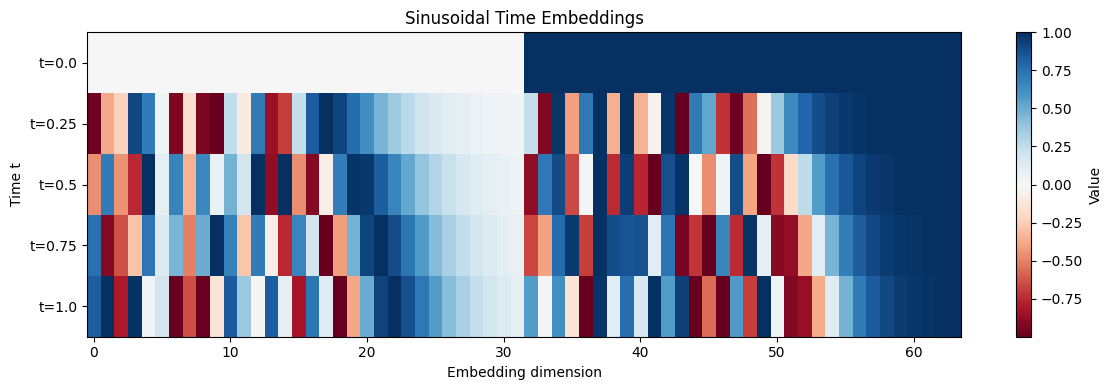

In [12]:
# Test
time_emb = SinusoidalTimeEmbedding(64)
t_test = torch.tensor([0.0, 0.25, 0.5, 0.75, 1.0])
emb = time_emb(t_test)
print(f"Time embedding shape: {emb.shape}")  # [5, 64]

# Visualize
plt.figure(figsize=(12, 4))
plt.imshow(emb.detach().numpy(), aspect='auto', cmap='RdBu')
plt.xlabel('Embedding dimension')
plt.ylabel('Time t')
plt.yticks(range(5), ['t=0.0', 't=0.25', 't=0.5', 't=0.75', 't=1.0'])
plt.colorbar(label='Value')
plt.title('Sinusoidal Time Embeddings')
plt.tight_layout()
plt.show()

In [13]:
# MHA
from torchtune.modules import RotaryPositionalEmbeddings
# torchtune RopE implementation expects input shape [B, T, n_head, head_dim], matches the code below

class MHA(nn.Module):
    def __init__(self, n_embd, n_head, dropout=0.1):
        super().__init__()
        assert n_embd % n_head == 0

        self.n_head = n_head
        self.n_embd = n_embd
        self.head_dim = n_embd // n_head

        self.c_attn = nn.Linear(n_embd, 3*n_embd)
        self.c_proj = nn.Linear(n_embd, n_embd)

        self.rope = RotaryPositionalEmbeddings(dim=n_embd // n_head)

        self.attn_dropout = nn.Dropout(dropout)
        self.residual_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        # atten_c: [n_embd, 3*n_embd];
        # x: [B, T, n_embd];
        # attn_c(x): [B, T, n_embd]@[n_embd, 3*n_embd]=[B, T, 3*n_embd]
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2) # [B, T, 3*n_embd] ==> 3 * [B, T, n_embd]

        q = q.view(B, T, self.n_head, self.head_dim) # [B, T, n_embd] = [B, T, n_head*head_dim] ==> [B, T, n_head, head_dim]
        # apply RoPE before transpose
        q = self.rope(q)
        q = q.transpose(1, 2) # [B, n_head, T, head_dim]
        k = k.view(B, T, self.n_head, self.head_dim)
        k = self.rope(k)
        k = k.transpose(1, 2) # [B, n_head, T, head_dim]
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        # k.transpose(-2, -1).shape: [B, n_head, head_dim, T]
        # (q @ k.transpose(-2, -1)).shape: [B, n_head, T, head_dim]@[B, n_head, head_dim, T] = [B, n_head, T, T]
        attn = (q @ k.transpose(-2, -1)*(1.0 / math.sqrt(self.head_dim))) # [B, n_head, T, T]

        # No causal mask

        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)

        out = attn @ v # [B, n_head, T, T]@[B, n_head, T, head_dim] = [B, n_head, T, head_dim]
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        # drop out on the residual stream
        out = self.residual_dropout(self.c_proj(out)) # [B, T, C]@[C, C]=[B, T, C]

        return out


In [14]:
class SwiGLU(nn.Module):
    """
    SwiGLU activation function.

    This effectively implements:
    SwiGLU(x) = (xW + b) * SiLU(xV + c)

    Where the input is split into two parts: one for the 'value' path
    and one for the 'gate' path.
    """
    def forward(self, x):
        # Split the input tensor into two halves along the last dimension
        x, gate = x.chunk(2, dim=-1)
        # Apply SiLU (Swish) to the gate and multiply with the value
        return x * F.silu(gate)

In [15]:
# FFN

class FFN(nn.Module):
    def __init__(self, n_embd, dropout=0.1):
        super().__init__()
        self.c_fc = nn.Linear(n_embd, 8*n_embd)
        self.swiglu = SwiGLU()
        self.c_proj = nn.Linear(4*n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x) # [B, T, C]@[C, 4*C]=[B, T, 4*C]
        x = self.swiglu(x)
        x = self.c_proj(x) # [B, T, 4*C]@[4*C, C]=[B, T, C]
        x = self.dropout(x) # [B, T, C]

        return x

In [16]:
# Block

class Block(nn.Module):
    def __init__(self, n_embd, n_head, dropout=0.1, use_time=True):
        super().__init__()
        self.use_time = use_time
        self.rms_norm_1 = nn.RMSNorm(n_embd)
        self.rms_norm_2 = nn.RMSNorm(n_embd)
        self.attn = MHA(n_embd, n_head, dropout)
        self.ffn = FFN(n_embd, dropout)

        # RMSNorm is designed to be "shift-invariant" (it centers data around 0), in Diffusion models, injecting the shift (beta) back in after normalization is a powerful way to tell the network about the noise level
        if use_time:
            self.time_ffn = nn.Sequential(
                nn.Linear(n_embd, 2 * n_embd),
                SwiGLU(), # SwiGLU will half the feature dimension
                nn.Linear(n_embd, 4*n_embd)
            )

    def forward(self, x, time_emb=None):
        if self.use_time and time_emb is not None:
            time_params = self.time_ffn(time_emb) # [B, e_embd]@[n_embd, 4*n_embd]=[B, 4*n_embd]
            shift1, scale1, shift2, scale2 = time_params.chunk(4, dim=-1) # [B, n_embd]

            h = self.rms_norm_1(x) * (1 + scale1.unsqueeze(1)) + shift1.unsqueeze(1) # [B, T, C]*[B, 1, C]+[B, 1, C]=[B, T, C]
            x = x + self.attn(h)
            h = self.rms_norm_2(x) * (1 + scale2.unsqueeze(1)) + shift2.unsqueeze(1) # [B, T, C]*[B, 1, C]+[B, 1, C]=[B, T, C]
            x = x + self.ffn(h) # [B, T, C]
        else:
            x = x + self.attn(self.rms_norm_1(x))
            x = x + self.ffn(self.rms_norm_2(x))

        return x


In [17]:
# Full MDLM

class MDLM(nn.Module):
    def __init__(
            self,
            vocab_size,
            n_embd,
            n_head,
            n_block,
            block_size,
            dropout=0.1,
            use_time = True
    ):
        super().__init__()

        self.block_size = block_size
        self.use_time = use_time
        self.tok_emb = nn.Embedding(vocab_size, n_embd)
        if use_time:
            self.time_emb = SinusoidalTimeEmbedding(n_embd)
            self.time_proj = nn.Sequential(
                nn.Linear(n_embd, 2*n_embd),
                SwiGLU(),
                nn.Linear(n_embd, n_embd)
            )
        self.blocks = nn.ModuleList([
            Block(n_embd, n_head, dropout, use_time) for _ in range(n_block)
        ])

        self.rms_norm_final = nn.RMSNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)

        # tie input and output embedding weights
        self.lm_head.weight = self.tok_emb.weight

        self.dropout = nn.Dropout(dropout)
        self.apply(self._init_weights)

        n_params = sum(p.numel() for p in self.parameters())
        print(f'Model has {n_params/1e6:.2f}M parameters.')

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.RMSNorm):
            torch.nn.init.ones_(module.weight)

    def forward(self, x, t=None):
        B, T = x.shape

        tok_emb = self.tok_emb(x) # [B, T, n_embd]
        h = self.dropout(tok_emb)

        if self.use_time and t is not None:
            t_emb = self.time_emb(t) # [B, n_embd]
            t_emb = self.time_proj(t_emb) # [B, n_embd]
        else:
            t_emb = None

        for block in self.blocks:
            h = block(h, t_emb)

        h = self.rms_norm_final(h)
        logits = self.lm_head(h) # [B, T, V]

        return logits

In [18]:
# Instantiate model

model = MDLM(
    vocab_size=final_vocab_size,
    n_embd=n_embd,
    n_head=n_head,
    n_block=n_blocks,
    block_size=block_size,
).to(device)

Model has 24.41M parameters.


In [ ]:
# # Pre-flight Check

# # Create a dummy batch
# dummy_x = next(iter(dataloader)) # Get real data format
# dummy_t = torch.rand(batch_size).to(device) # Random time
# dummy_x = dummy_x.to(device)

# # 1. Test Masking
# x_masked, mask = mask_tokens(dummy_x, dummy_t, MASK_TOKEN)
# print(f"Masking shape: {x_masked.shape} ✅")

# # 2. Test Model Forward
# logits = model(x_masked, dummy_t)
# print(f"Logits shape: {logits.shape} (Expected: [{batch_size}, {block_size}, {final_vocab_size}]) ✅")

# # 3. Test Loss Calculation
# loss = compute_loss(model, dummy_x, MASK_TOKEN)
# print(f"Loss calculation: {loss.item():.4f} ✅")

# print("\nSystem Status: GREEN. Ready to train.")

Masking shape: torch.Size([8, 1024]) ✅
Logits shape: torch.Size([8, 1024, 91]) (Expected: [8, 1024, 91]) ✅
Loss calculation: 4.6857 ✅

System Status: GREEN. Ready to train.


In [19]:
# training loop

from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

import os
import time

CKPT_DIR = '/content/drive/MyDrive/Colab Notebooks/MDLM/ckpt'
CKPT_PATH = os.path.join(CKPT_DIR, 'latest.pt')
os.makedirs(CKPT_DIR, exist_ok=True)

def train(model, dataloader, epochs, lr=3e-4, warmup_steps=1000, save_interval_minutes=20):
    """Training loop with float16 AMP, auto-resume, and periodic checkpointing."""

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    scaler = torch.cuda.amp.GradScaler()

    total_steps = len(dataloader) * epochs

    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = LambdaLR(optimizer, lr_lambda)

    # ============================================================
    # AUTO-RESUME: Check for existing checkpoint
    # ============================================================
    start_epoch = 0
    global_step = 0
    losses = []

    if os.path.exists(CKPT_PATH):
        print(f"📂 Found checkpoint at {CKPT_PATH}")
        checkpoint = torch.load(CKPT_PATH, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        global_step = checkpoint['global_step']
        losses = checkpoint['losses']
        print(f"✅ Resuming from epoch {start_epoch + 1}, step {global_step}")
    else:
        print("🆕 No checkpoint found, starting fresh")
    print("-" * 50)

    # ============================================================
    # SAVE CHECKPOINT FUNCTION
    # ============================================================
    def save_checkpoint(epoch, step):
        torch.save({
            'epoch': epoch,
            'global_step': step,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'losses': losses,
        }, CKPT_PATH)
        print(f"\n💾 Checkpoint saved at epoch {epoch + 1}, step {step}")

    # ============================================================
    # TRAINING LOOP
    # ============================================================
    model.train()
    device_type = device.type
    print(f"Training with float16 on {device_type}")

    last_save_time = time.time()

    for epoch in range(start_epoch, epochs):
        epoch_losses = []

        pbar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{epochs}')
        for batch_idx, batch in enumerate(pbar):
            x_0 = batch.to(device)

            with torch.autocast(device_type=device_type, dtype=torch.float16):
                loss = compute_loss(model, x_0, MASK_TOKEN)

            scaler_loss = loss / grad_accum_steps
            scaler.scale(scaler_loss).backward()

            if (batch_idx + 1) % grad_accum_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() # Clear gradients after step. accumulate gradient, step, then clear
                scheduler.step()

            epoch_losses.append(loss.item())
            losses.append(loss.item())
            global_step += 1

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })

            # === AUTOSAVE EVERY N MINUTES ===
            if (time.time() - last_save_time) / 60 >= save_interval_minutes:
                save_checkpoint(epoch, global_step)
                last_save_time = time.time()

        avg_loss = sum(epoch_losses) / len(epoch_losses)
        print(f"Epoch {epoch + 1} average loss: {avg_loss:.4f}")

    save_checkpoint(epochs - 1, global_step)
    print("✅ Training complete!")

    return losses

In [20]:
# start training

losses = train(model, dataloader, epochs=50, lr=3e-4)

/tmp/ipython-input-2557444503.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


🆕 No checkpoint found, starting fresh
--------------------------------------------------
Training with float16 on cuda


Epoch 1/50: 100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, loss=4.5519, lr=9.36e-05]


Epoch 1 average loss: 4.8313


Epoch 2/50: 100%|██████████| 1250/1250 [02:44<00:00,  7.59it/s, loss=4.0693, lr=1.87e-04]


Epoch 2 average loss: 4.2311


Epoch 3/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.52it/s, loss=3.7803, lr=2.81e-04]


Epoch 3 average loss: 3.7951


Epoch 4/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.50it/s, loss=3.5407, lr=3.00e-04]


Epoch 4 average loss: 3.4878


Epoch 5/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.49it/s, loss=2.9995, lr=3.00e-04]


Epoch 5 average loss: 3.2897


Epoch 6/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.51it/s, loss=3.4976, lr=3.00e-04]


Epoch 6 average loss: 3.2021


Epoch 7/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.50it/s, loss=3.0656, lr=3.00e-04]


Epoch 7 average loss: 3.1251


Epoch 8/50:  25%|██▍       | 309/1250 [00:42<05:13,  3.00it/s, loss=3.0258, lr=3.00e-04]


💾 Checkpoint saved at epoch 8, step 9058


Epoch 8/50: 100%|██████████| 1250/1250 [02:48<00:00,  7.44it/s, loss=3.3265, lr=3.00e-04]


Epoch 8 average loss: 3.0835


Epoch 9/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.46it/s, loss=3.0828, lr=2.99e-04]


Epoch 9 average loss: 3.0631


Epoch 10/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.47it/s, loss=3.0981, lr=2.99e-04]


Epoch 10 average loss: 3.0227


Epoch 11/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.47it/s, loss=2.7023, lr=2.99e-04]


Epoch 11 average loss: 3.0141


Epoch 12/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.48it/s, loss=3.3057, lr=2.99e-04]


Epoch 12 average loss: 2.9963


Epoch 13/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.46it/s, loss=2.9201, lr=2.98e-04]


Epoch 13 average loss: 2.9690


Epoch 14/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.47it/s, loss=3.3645, lr=2.98e-04]


Epoch 14 average loss: 2.9410


Epoch 15/50:  42%|████▏     | 524/1250 [01:11<04:18,  2.81it/s, loss=2.8616, lr=2.98e-04]


💾 Checkpoint saved at epoch 15, step 18023


Epoch 15/50: 100%|██████████| 1250/1250 [02:48<00:00,  7.40it/s, loss=2.8398, lr=2.97e-04]


Epoch 15 average loss: 2.9441


Epoch 16/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.47it/s, loss=2.8709, lr=2.97e-04]


Epoch 16 average loss: 2.9277


Epoch 17/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.47it/s, loss=2.7284, lr=2.96e-04]


Epoch 17 average loss: 2.9145


Epoch 18/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.47it/s, loss=2.7808, lr=2.96e-04]


Epoch 18 average loss: 2.9015


Epoch 19/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.46it/s, loss=3.0460, lr=2.95e-04]


Epoch 19 average loss: 2.8943


Epoch 20/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.48it/s, loss=2.9252, lr=2.95e-04]


Epoch 20 average loss: 2.8906


Epoch 21/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.49it/s, loss=2.5297, lr=2.94e-04]


Epoch 21 average loss: 2.8701


Epoch 22/50:  59%|█████▉    | 740/1250 [01:42<07:46,  1.09it/s, loss=3.0550, lr=2.94e-04]


💾 Checkpoint saved at epoch 22, step 26989


Epoch 22/50: 100%|██████████| 1250/1250 [02:50<00:00,  7.32it/s, loss=3.1330, lr=2.93e-04]


Epoch 22 average loss: 2.8666


Epoch 23/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.49it/s, loss=2.8515, lr=2.93e-04]


Epoch 23 average loss: 2.8587


Epoch 24/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.49it/s, loss=2.4474, lr=2.92e-04]


Epoch 24 average loss: 2.8469


Epoch 25/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.49it/s, loss=3.4100, lr=2.91e-04]


Epoch 25 average loss: 2.8592


Epoch 26/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.50it/s, loss=2.7564, lr=2.90e-04]


Epoch 26 average loss: 2.8458


Epoch 27/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.48it/s, loss=2.7202, lr=2.89e-04]


Epoch 27 average loss: 2.8366


Epoch 28/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.47it/s, loss=2.9378, lr=2.88e-04]


Epoch 28 average loss: 2.8523


Epoch 29/50:  78%|███████▊  | 973/1250 [02:11<01:26,  3.19it/s, loss=3.1189, lr=2.88e-04]


💾 Checkpoint saved at epoch 29, step 35972


Epoch 29/50: 100%|██████████| 1250/1250 [02:48<00:00,  7.42it/s, loss=2.9899, lr=2.88e-04]


Epoch 29 average loss: 2.8253


Epoch 30/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.46it/s, loss=3.2239, lr=2.87e-04]


Epoch 30 average loss: 2.8202


Epoch 31/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.47it/s, loss=3.1182, lr=2.86e-04]


Epoch 31 average loss: 2.8117


Epoch 32/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.49it/s, loss=2.5079, lr=2.84e-04]


Epoch 32 average loss: 2.8140


Epoch 33/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.51it/s, loss=2.7929, lr=2.83e-04]


Epoch 33 average loss: 2.8115


Epoch 34/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.51it/s, loss=3.1724, lr=2.82e-04]


Epoch 34 average loss: 2.8032


Epoch 35/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.51it/s, loss=2.7326, lr=2.81e-04]


Epoch 35 average loss: 2.7983


Epoch 36/50:  97%|█████████▋| 1212/1250 [02:42<00:12,  2.98it/s, loss=2.9888, lr=2.80e-04]


💾 Checkpoint saved at epoch 36, step 44961


Epoch 36/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.47it/s, loss=2.8964, lr=2.80e-04]


Epoch 36 average loss: 2.8027


Epoch 37/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.51it/s, loss=2.5297, lr=2.79e-04]


Epoch 37 average loss: 2.7976


Epoch 38/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.51it/s, loss=2.9047, lr=2.78e-04]


Epoch 38 average loss: 2.7788


Epoch 39/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.51it/s, loss=2.6023, lr=2.76e-04]


Epoch 39 average loss: 2.7856


Epoch 40/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.51it/s, loss=3.0209, lr=2.75e-04]


Epoch 40 average loss: 2.7717


Epoch 41/50: 100%|██████████| 1250/1250 [02:47<00:00,  7.48it/s, loss=3.1639, lr=2.74e-04]


Epoch 41 average loss: 2.7758


Epoch 42/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.50it/s, loss=3.2497, lr=2.72e-04]


Epoch 42 average loss: 2.7555


Epoch 43/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.51it/s, loss=2.5878, lr=2.71e-04]


Epoch 43 average loss: 2.7523


Epoch 44/50:  17%|█▋        | 216/1250 [00:29<05:45,  2.99it/s, loss=2.8377, lr=2.71e-04]


💾 Checkpoint saved at epoch 44, step 53965


Epoch 44/50: 100%|██████████| 1250/1250 [02:48<00:00,  7.43it/s, loss=2.8304, lr=2.69e-04]


Epoch 44 average loss: 2.7455


Epoch 45/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.52it/s, loss=3.0135, lr=2.68e-04]


Epoch 45 average loss: 2.7660


Epoch 46/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.52it/s, loss=2.7193, lr=2.66e-04]


Epoch 46 average loss: 2.7548


Epoch 47/50: 100%|██████████| 1250/1250 [02:46<00:00,  7.50it/s, loss=2.9277, lr=2.65e-04]


Epoch 47 average loss: 2.7551


Epoch 48/50: 100%|██████████| 1250/1250 [02:45<00:00,  7.54it/s, loss=2.6876, lr=2.63e-04]


Epoch 48 average loss: 2.7396


Epoch 49/50: 100%|██████████| 1250/1250 [02:45<00:00,  7.54it/s, loss=2.5725, lr=2.62e-04]


Epoch 49 average loss: 2.7517


Epoch 50/50: 100%|██████████| 1250/1250 [02:45<00:00,  7.54it/s, loss=2.6376, lr=2.60e-04]


Epoch 50 average loss: 2.7522

💾 Checkpoint saved at epoch 50, step 62500
✅ Training complete!


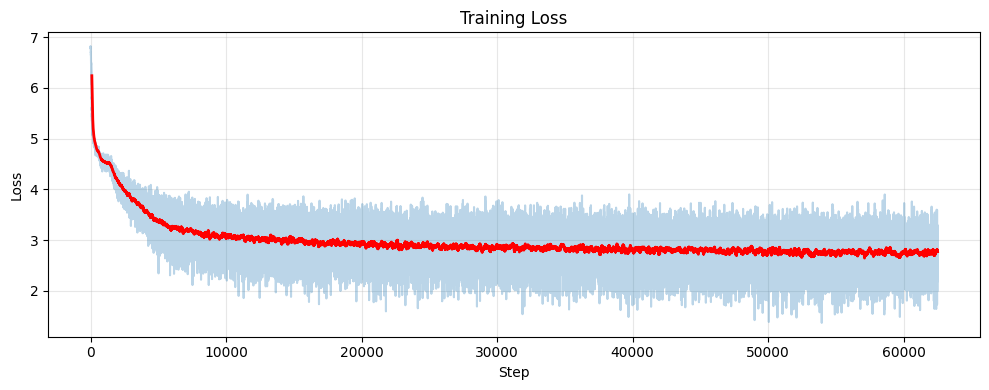

In [21]:
# Plot loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses, alpha=0.3)
# Smoothed
window = 100
smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(losses)), smoothed, 'r', linewidth=2)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()